            USD/JPY_mid  USD/JPY_ask  USD/JPY_bid   price   returns
Date                                                               
2009-01-06       93.535        93.53        93.54  93.535  0.016464
2009-01-07       93.475        93.46        93.49  93.475 -0.000641
2009-01-08       91.765        91.76        91.77  91.765 -0.018294
2009-01-09       91.160        91.15        91.17  91.160 -0.006593
2009-01-13       89.265        89.25        89.28  89.265 -0.020788
Number of data points from 2019-01-01: 1219


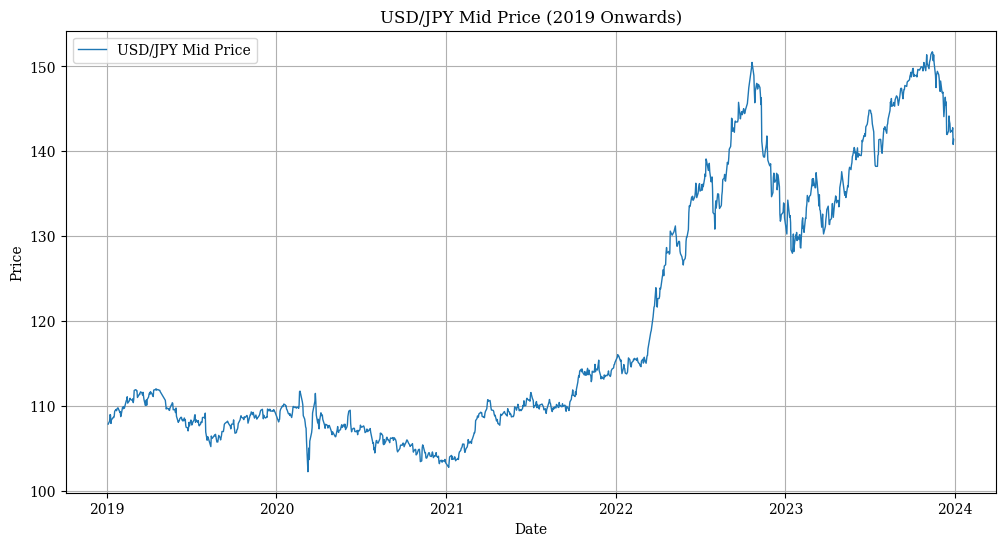

In [693]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# データ読み込みと前処理
file_path = '/Users/k.tsuji/Finance_assignment/USD:JPY3.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
data['price'] = data['USD/JPY_mid']
data['returns'] = data['price'].pct_change()
data.dropna(inplace=True)

print(data.head(5))

# 2019年1月1日以降のデータをフィルタリング
filtered_data = data.loc['2019-01-01':]

# 2019年1月1日以降の 'returns' のデータ数を出力
print("Number of data points from 2019-01-01:", len(filtered_data['returns']))


# 2019年1月1日以降のデータをフィルタリング
data_2019_onwards = data.loc['2019-01-01':]

# プライスの時系列グラフ
plt.figure(figsize=(12, 6))
plt.plot(data_2019_onwards.index, data_2019_onwards['price'], label='USD/JPY Mid Price', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('USD/JPY Mid Price (2019 Onwards)')
plt.legend()
plt.grid()
plt.show()


In [694]:
# USD/JPY_mid 列を使用
symbol = "USD/JPY_mid"
data['returns'] = data[symbol].pct_change()
data.dropna(inplace=True)

print((data.head(3)))

            USD/JPY_mid  USD/JPY_ask  USD/JPY_bid   price   returns
Date                                                               
2009-01-07       93.475        93.46        93.49  93.475 -0.000641
2009-01-08       91.765        91.76        91.77  91.765 -0.018294
2009-01-09       91.160        91.15        91.17  91.160 -0.006593


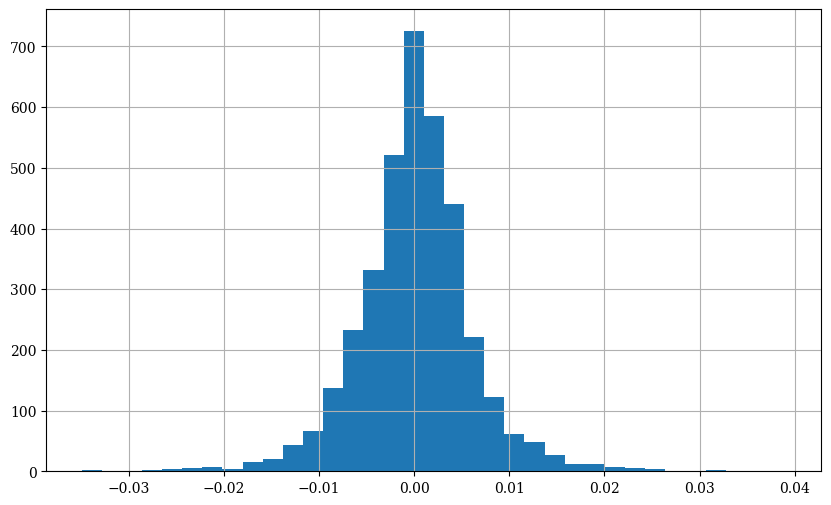

In [695]:
data['returns'].hist(bins=35, figsize=(10, 6));


Running backtest for lag 3
Lag 3: MSE=0.000047, R2=-0.0257
Win Rate: 51.22%, Max Drawdown: -9.92%, Final Return: -3.93%
Number of Trades: 168

Running backtest for lag 5
Lag 5: MSE=0.000046, R2=-0.0191
Win Rate: 51.22%, Max Drawdown: -9.96%, Final Return: -0.90%
Number of Trades: 162

Running backtest for lag 15
Lag 15: MSE=0.000048, R2=-0.0417
Win Rate: 54.88%, Max Drawdown: -11.26%, Final Return: 3.08%
Number of Trades: 150


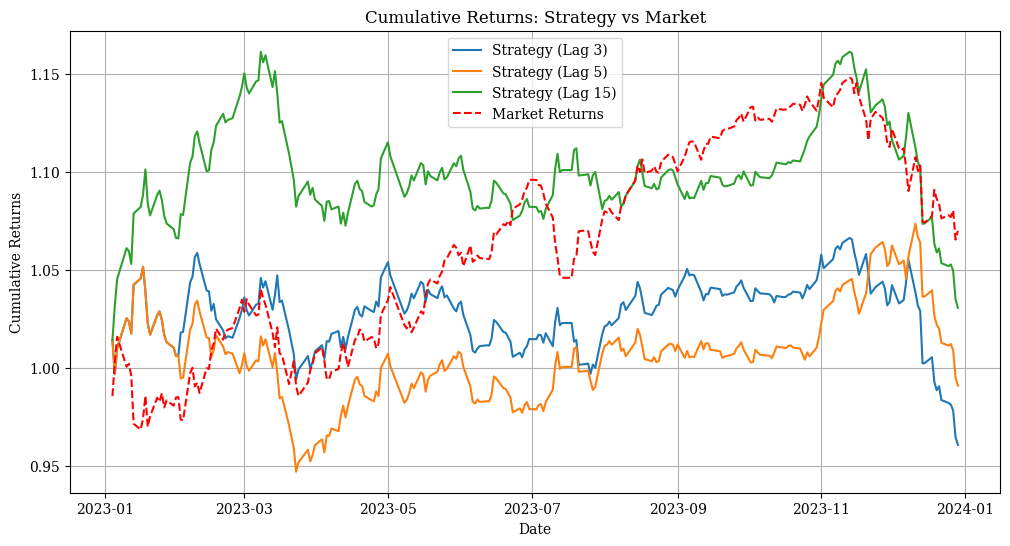

In [705]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ラグ変数の作成
def create_lags(data, max_lag):
    data_copy = data.copy()
    for i in range(1, max_lag + 1):
        data_copy[f'lag_{i}'] = data_copy['returns'].shift(i)
    return data_copy.dropna()

# パフォーマンス指標計算
def calculate_performance_metrics(test_data):
    metrics = {}
    cumulative_returns = (1 + test_data['strategy_returns']).cumprod()

    # 勝率
    wins = (test_data['strategy_returns'] > 0).sum()
    total_trades = len(test_data['strategy_returns'])
    metrics['Win Rate'] = wins / total_trades if total_trades > 0 else 0

    # 最大ドローダウン
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    metrics['Max Drawdown'] = drawdown.min()

    # 最終リターン
    metrics['Final Return'] = cumulative_returns.iloc[-1] - 1

    # 取引回数
    metrics['Number of Trades'] = (test_data['pos'].diff().abs() > 0).sum()

    return metrics

# バックテスト実行
def run_backtest(data, max_lag):
    # ラグ変数の生成
    data_with_lags = create_lags(data, max_lag)
    train_data = data_with_lags.loc['2019-01-01':'2022-12-31']
    test_data = data_with_lags.loc['2023-01-01':'2023-12-31']

    # 線形回帰モデルの学習
    X_train = train_data[[f'lag_{i}' for i in range(1, max_lag + 1)]]
    y_train = train_data['returns']
    model = LinearRegression()
    model.fit(X_train, y_train)

    # テストデータで予測とポジション計算
    X_test = test_data[[f'lag_{i}' for i in range(1, max_lag + 1)]]
    test_data['predicted_returns'] = model.predict(X_test)
    test_data['pos'] = np.where(test_data['predicted_returns'] > 0, 1, -1)
    test_data['strategy_returns'] = test_data['pos'] * test_data['returns']
    test_data['cumulative_strategy'] = (1 + test_data['strategy_returns']).cumprod()
    test_data['cumulative_market'] = (1 + test_data['returns']).cumprod()

    # モデル評価
    mse = mean_squared_error(test_data['returns'], test_data['predicted_returns'])
    r2 = r2_score(test_data['returns'], test_data['predicted_returns'])
    metrics = calculate_performance_metrics(test_data)

    print(f"Lag {max_lag}: MSE={mse:.6f}, R2={r2:.4f}")
    print(f"Win Rate: {metrics['Win Rate']:.2%}, Max Drawdown: {metrics['Max Drawdown']:.2%}, Final Return: {metrics['Final Return']:.2%}")
    print(f"Number of Trades: {metrics['Number of Trades']}")

    return test_data, metrics

# バックテスト実行とプロット
lag_settings = [3, 5, 15]
results = {}

plt.figure(figsize=(12, 6))
for max_lag in lag_settings:
    print(f"\nRunning backtest for lag {max_lag}")
    results[max_lag], metrics = run_backtest(data, max_lag)
    plt.plot(results[max_lag].index, results[max_lag]['cumulative_strategy'], label=f'Strategy (Lag {max_lag})')

# 市場リターンをプロット
plt.plot(results[3].index, results[3]['cumulative_market'], label='Market Returns', linestyle='--', color='red')

# グラフの装飾
plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()



Running Naive Bayes Model
Accuracy: 0.5488, Final Return: 0.1189, Max Drawdown: -0.0546, Number of Trades: 116


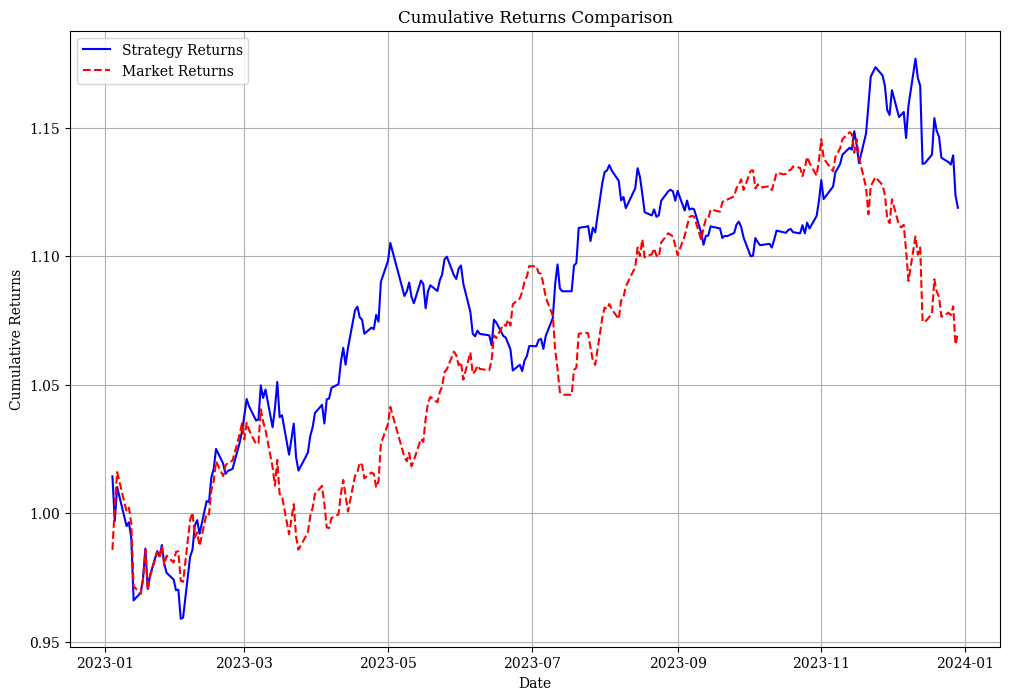

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import talib as ta

# 特徴量作成
def add_features(data):
    close = data['USD/JPY_mid'].values
    data['returns'] = data['USD/JPY_mid'].pct_change()
    for i in range(1, 6):
        data[f'lag_{i}'] = data['returns'].shift(i)
    data['sma_5'] = data['USD/JPY_mid'].rolling(window=5).mean() / data['USD/JPY_mid']
    data['sma_30'] = data['USD/JPY_mid'].rolling(window=30).mean() / data['USD/JPY_mid']
    data['rsi'] = ta.RSI(close, timeperiod=14)
    data['macd'], _, _ = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    for col in ['sma_5', 'sma_30', 'rsi', 'macd']:
        data[col] = data[col].shift(1)
    return data.dropna()

# パフォーマンス指標計算
def calculate_performance_metrics(test_data):
    metrics = {}
    cumulative_returns = (1 + test_data['strategy_returns']).cumprod()
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    metrics['Max Drawdown'] = drawdown.min()
    metrics['Number of Trades'] = (test_data['pos'].diff().abs() > 0).sum()
    metrics['Final Return'] = cumulative_returns.iloc[-1] - 1
    return metrics

# バックテスト
def run_backtest_naive_bayes(data, features, k=5):
    train_data = data.loc['2019-01-01':'2022-12-31']
    test_data = data.loc['2023-01-01':'2023-12-31']

    X_train, y_train = train_data[features], train_data['returns']
    y_train_binary = (y_train > 0).astype(int)
    X_test, y_test = test_data[features], (test_data['returns'] > 0).astype(int)

    # 欠損値処理
    X_train, X_test = X_train.dropna(), X_test.dropna()
    y_train, y_train_binary = y_train[X_train.index], y_train_binary[X_train.index]
    y_test = y_test[X_test.index]

    # 特徴量選択
    selector = SelectKBest(score_func=f_classif, k=min(k, len(features)))
    X_train_selected = selector.fit_transform(X_train, y_train_binary)
    X_test_selected = selector.transform(X_test)
    selected_features = pd.DataFrame({
        'feature': np.array(features)[selector.get_support()],
        'score': selector.scores_[selector.get_support()]
    }).sort_values('score', ascending=False)

    # モデル学習と予測
    model = GaussianNB()
    model.fit(X_train_selected, y_train_binary)
    test_data = test_data.loc[X_test.index].copy()
    test_data['predicted_prob'] = model.predict_proba(X_test_selected)[:, 1]
    test_data['pos'] = np.where(test_data['predicted_prob'] > 0.5, 1, -1)
    test_data['strategy_returns'] = test_data['pos'] * test_data['returns']
    test_data['cumulative_strategy'] = (1 + test_data['strategy_returns']).cumprod()
    test_data['cumulative_market'] = (1 + test_data['returns']).cumprod()

    accuracy = accuracy_score(y_test, model.predict(X_test_selected))
    metrics = calculate_performance_metrics(test_data)
    print(f"Accuracy: {accuracy:.4f}, Final Return: {metrics['Final Return']:.4f}, Max Drawdown: {metrics['Max Drawdown']:.4f}, Number of Trades: {metrics['Number of Trades']}")
    return test_data, accuracy, model, selected_features

# 実行
data = add_features(data)
features = [f'lag_{i}' for i in range(1, 6)] + ['sma_5', 'sma_30', 'rsi', 'macd']

# バックテストの実行
print("\nRunning Naive Bayes Model")
test_data, accuracy, model, selected_features = run_backtest_naive_bayes(data, features, k=5)

# 累積リターンプロット
plt.figure(figsize=(12, 8))
plt.plot(test_data.index, test_data['cumulative_strategy'], label='Strategy Returns', color='blue')
plt.plot(test_data.index, test_data['cumulative_market'], label='Market Returns', color='red', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


[I 2025-01-26 22:58:50,527] A new study created in memory with name: no-name-173a0d6b-4588-49cf-93c5-dad21f8456fe
[I 2025-01-26 22:58:50,607] Trial 0 finished with value: 0.47540983606557374 and parameters: {'n_estimators': 60, 'max_depth': 30, 'min_samples_split': 16, 'criterion': 'gini'}. Best is trial 0 with value: 0.47540983606557374.
[I 2025-01-26 22:58:50,619] Trial 1 finished with value: 0.5491803278688525 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 18, 'criterion': 'entropy'}. Best is trial 0 with value: 0.47540983606557374.
[I 2025-01-26 22:58:50,632] Trial 2 finished with value: 0.5040983606557377 and parameters: {'n_estimators': 10, 'max_depth': 30, 'min_samples_split': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.47540983606557374.
[I 2025-01-26 22:58:50,644] Trial 3 finished with value: 0.49590163934426235 and parameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 13, 'criterion': 'gini'}. Best is trial 0 with value:

Best Params: {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 20, 'criterion': 'gini'}, Best Validation Accuracy: 0.5328
Test Accuracy: 0.5041, Final Return: 0.0925, Max Drawdown: -0.0654, Number of Trades: 105


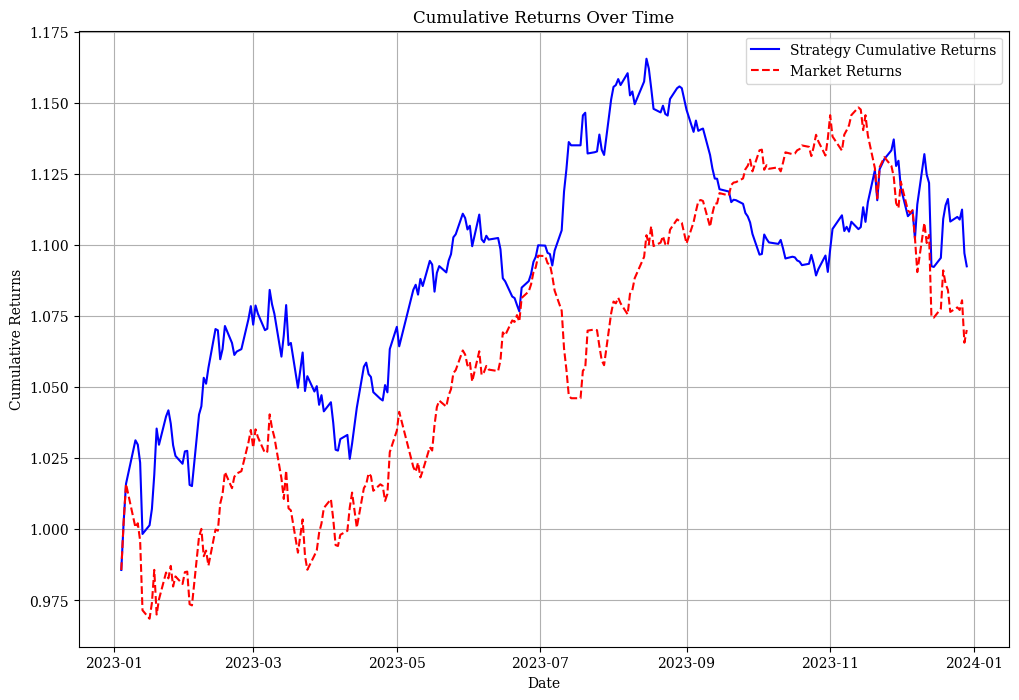

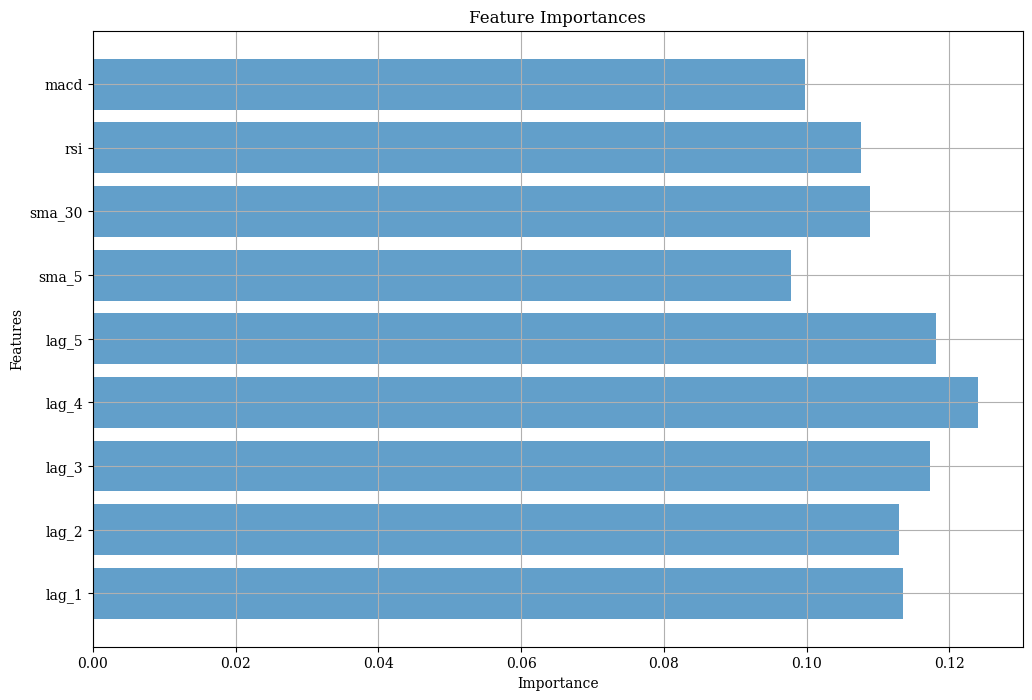

In [714]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna

# データ分割関数
def split_train_validation(data):
    train_data = data.loc['2019-01-01':'2021-12-31']
    val_data = data.loc['2022-01-01':'2022-12-31']
    return train_data, val_data

# ハイパーパラメータ最適化関数
def optimize_hyperparameters(train_data, val_data, features):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200, step=50),
            'max_depth': trial.suggest_int('max_depth', 5, 30, step=5),
            'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
        }
        model = RandomForestClassifier(random_state=0, **params)
        model.fit(train_data[features], (train_data['returns'] > 0).astype(int))
        val_preds = model.predict(val_data[features])
        val_score = accuracy_score((val_data['returns'] > 0).astype(int), val_preds)
        return 1 - val_score

    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=100)
    best_params = study.best_params
    best_score = 1 - study.best_value
    print(f"Best Params: {best_params}, Best Validation Accuracy: {best_score:.4f}")
    return best_params

# パフォーマンス指標計算関数
def calculate_performance_metrics(test_data):
    cumulative_returns = (1 + test_data['strategy_returns']).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    final_return = cumulative_returns.iloc[-1] - 1
    number_of_trades = (test_data['pos'].diff().abs() > 0).sum()
    return final_return, max_drawdown, number_of_trades

# バックテスト関数
def run_backtest(data, features, best_params):
    train_data = data.loc['2019-01-01':'2022-12-31']
    test_data = data.loc['2023-01-01':'2023-12-31']
    X_train, y_train = train_data[features], (train_data['returns'] > 0).astype(int)
    X_test, y_test = test_data[features], (test_data['returns'] > 0).astype(int)

    model = RandomForestClassifier(random_state=42, **best_params)
    model.fit(X_train, y_train)
    test_data['predicted_prob'] = model.predict_proba(X_test)[:, 1]
    test_data['pos'] = np.where(test_data['predicted_prob'] > 0.5, 1, -1)
    test_data['strategy_returns'] = test_data['pos'] * test_data['returns']
    test_data['cumulative_strategy'] = (1 + test_data['strategy_returns']).cumprod()
    test_data['cumulative_market'] = (1 + test_data['returns']).cumprod()

    accuracy = accuracy_score(y_test, model.predict(X_test))
    final_return, max_drawdown, number_of_trades = calculate_performance_metrics(test_data)

    print(f"Test Accuracy: {accuracy:.4f}, Final Return: {final_return:.4f}, Max Drawdown: {max_drawdown:.4f}, Number of Trades: {number_of_trades}")
    return test_data, accuracy, final_return, max_drawdown, number_of_trades, model

# トレインとバリデーションの分割
train_data, val_data = split_train_validation(data)

# ハイパーパラメータ探索
best_params = optimize_hyperparameters(train_data, val_data, features)

# テストデータでバックテスト
test_data, accuracy, final_return, max_drawdown, number_of_trades, model = run_backtest(data, features, best_params)

# 累積リターンプロット
plt.figure(figsize=(12, 8))
plt.plot(test_data.index, test_data['cumulative_strategy'], label='Strategy Cumulative Returns', color='blue')
plt.plot(test_data.index, test_data['cumulative_market'], label='Market Returns', color='red', linestyle='--')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

# 特徴量重要度プロット
plt.figure(figsize=(12, 8))
plt.barh(features, model.feature_importances_, alpha=0.7)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid()
plt.show()